# **TF - Procesamiento de Imágenes**
### Integrantes: Rafael Chui, Axel Pariona, Rodrigo Meza, Liam Quino


## **Descarga y creación del dataset de imágenes de personajes**

## Importación de librerías y configuración inicial

In [1]:
import os
import csv
import requests
from pathlib import Path
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from concurrent.futures import ThreadPoolExecutor
import torchvision.transforms as transforms

## Preparación del dataset y anotaciones

In [2]:
import os

dataset_dir = "street_fighter_dataset"
class_names = sorted([
    name for name in os.listdir(dataset_dir)
    if os.path.isdir(os.path.join(dataset_dir, name))
])

with open("classes.txt", "w", encoding="utf-8") as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")

print(f"Archivo 'classes.txt' generado con {len(class_names)} clases.")


Archivo 'classes.txt' generado con 15 clases.


## **Desarrollo del modelo**

## Importación de librerías y configuración inicial

In [3]:
import os
import cv2
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import rarfile
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

In [4]:
print("CUDA disponible:", torch.cuda.is_available())
print("Nombre de GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No hay GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA disponible: True
Nombre de GPU: NVIDIA GeForce RTX 3090


## Funciones para la extracción y preparación del dataset

In [5]:
def extraer_dataset(ruta_archivo):
    print("Extrayendo dataset...")
    if ruta_archivo.endswith(".rar"):
        with rarfile.RarFile(ruta_archivo) as rf:
            rf.extractall('.')
    elif ruta_archivo.endswith(".zip"):
        with zipfile.ZipFile(ruta_archivo, 'r') as zip_ref:
            zip_ref.extractall('.')
    else:
        raise ValueError("Formato no soportado. Usa .zip o .rar")
    print("Dataset extraído exitosamente")

def cargar_y_preparar_datos(dataset_path="street_fighter_dataset", img_size=(224,224)):
    print("Cargando datos del dataset...")
    dataset_path = Path(dataset_path)
    images = []
    labels = []
    class_names = []
    classes_file = Path("classes.txt")
    if classes_file.exists():
        with open(classes_file, 'r', encoding='latin1') as f:
            class_names = [line.strip() for line in f.readlines()]
    class_to_index = {name: idx for idx, name in enumerate(class_names)}

    for personaje_dir in dataset_path.iterdir():
        if personaje_dir.is_dir() and personaje_dir.name in class_names:
            class_idx = class_to_index[personaje_dir.name]
            for img_file in personaje_dir.glob("*.*"):
                if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                            try:
                                img = cv2.imread(str(img_file))
                                if img is not None:
                                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                                    img = cv2.resize(img, img_size)
                                    images.append(img)
                                    labels.append(class_idx)
                            except Exception as e:
                                print(f"Error cargando {img_file}: {e}")
    print(f"Cargadas {len(images)} imágenes de {len(class_names)} clases")
    return np.array(images), np.array(labels), class_names


## Extracción de las características clásicas del dataset

In [6]:
def extraer_caracteristicas_clasicas(images):
    print("Extrayendo características clásicas...")
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hist_r = cv2.calcHist([img[:,:,0]], [0], None, [32], [0, 256]).flatten()
        hist_g = cv2.calcHist([img[:,:,1]], [0], None, [32], [0, 256]).flatten()
        hist_b = cv2.calcHist([img[:,:,2]], [0], None, [32], [0, 256]).flatten()
        hist_gray = cv2.calcHist([gray], [0], None, [32], [0, 256]).flatten()
        edges = cv2.Canny(gray, 50, 150)
        edge_density = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])
        grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        grad_mag = np.sqrt(grad_x**2 + grad_y**2)
        texture_features = [np.mean(grad_mag), np.std(grad_mag),
                            np.mean(np.abs(grad_x)), np.mean(np.abs(grad_y))]
        moments = cv2.moments(gray)
        hu_moments = cv2.HuMoments(moments).flatten()
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
        feature_vector = np.concatenate([
            hist_r, hist_g, hist_b, hist_gray,
            [edge_density], texture_features, hu_moments
        ])
        features.append(feature_vector)
    return np.array(features)

## Entrenamiento de modelos clásicos (SVM y KNN)

In [7]:
from tqdm import tqdm

def entrenar_modelos_clasicos(X_features, y):
    print("Entrenando modelos clásicos...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_features)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
    svm_model = SVC(kernel='rbf', random_state=42)
    knn_model = KNeighborsClassifier(n_neighbors=5)
    # Entrenamiento con barra de progreso
    for model, name in zip([svm_model, knn_model], ['SVM', 'KNN']):
        print(f"Entrenando {name}...")
        with tqdm(total=1, desc=f"Entrenando {name}") as pbar:
            model.fit(X_train, y_train)
            pbar.update(1)
    svm_pred = svm_model.predict(X_test)
    knn_pred = knn_model.predict(X_test)
    svm_accuracy = accuracy_score(y_test, svm_pred)
    knn_accuracy = accuracy_score(y_test, knn_pred)
    mejor_modelo = svm_model if svm_accuracy > knn_accuracy else knn_model
    print(f"Mejor modelo clásico: {'SVM' if svm_accuracy > knn_accuracy else 'KNN'}")
    return {
        'svm_accuracy': svm_accuracy,
        'knn_accuracy': knn_accuracy,
        'svm_report': classification_report(y_test, svm_pred),
        'knn_report': classification_report(y_test, knn_pred),
        'y_test': y_test,
        'svm_pred': svm_pred,
        'knn_pred': knn_pred,
        'scaler': scaler,
        'mejor_modelo': mejor_modelo
    }

## Definición y entrenamiento del modelo CNN

In [8]:
from torchvision.models import resnet50

def crear_modelo_cnn_torch(num_clases):
    model = resnet50(weights="IMAGENET1K_V1")
    for param in model.parameters():
        param.requires_grad = False  # Congela capas base

    # Descongela las últimas capas para fine-tuning
    for param in model.layer4.parameters():
        param.requires_grad = True

    model.fc = nn.Sequential(
        nn.BatchNorm1d(model.fc.in_features),
        nn.Dropout(0.5),
        nn.Linear(model.fc.in_features, num_clases)
    )
    return model


def entrenar_modelo_cnn_torch(train_loader, test_loader, num_clases, device, epochs=40):
    model = crear_modelo_cnn_torch(num_clases).to(device)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)

    best_acc = 0
    patience = 10
    counter = 0

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluación
        model.eval()
        correct, total = 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = correct / total
        scheduler.step(accuracy)
        print(f"Epoch {epoch+1}/{epochs} - Accuracy: {accuracy:.4f}")

        if accuracy > best_acc:
            best_acc = accuracy
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping activado.")
                break

    return {
        'modelo': model,
        'test_accuracy': best_acc,
        'y_test': all_labels,
        'y_pred': all_preds
    }


## Ejecución de las funciones definidas para la creación y entrenamiento de los modelos

In [9]:
import torchvision.transforms as transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter

# Cargar y preparar los datos
X, y, class_names = cargar_y_preparar_datos()
# === FILTRADO DE CLASES CON SUFICIENTES IMÁGENES ===
min_imgs = 20  
counts = Counter(y)
clases_validas = [cls for cls, cnt in counts.items() if cnt >= min_imgs]
mask = np.isin(y, clases_validas)
X = X[mask]
y = y[mask]

# Remapea las etiquetas a 0...N-1 y actualiza class_names
clases_presentes = sorted(set(y))
old_to_new = {old: new for new, old in enumerate(clases_presentes)}
y = np.array([old_to_new[yy] for yy in y])
class_names = [class_names[i] for i in clases_presentes]
if len(X) == 0:
    print("No se encontraron imágenes.")
else:
    # Define transforms para entrenamiento y test
    
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
        transforms.RandomHorizontalFlip(),
        AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.25)
    ])

    test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # Divide los datos en entrenamiento y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Aplica los transforms a los arrays numpy
    X_train_aug = np.stack([train_transform(img).numpy() for img in X_train])
    X_test_aug = np.stack([test_transform(img).numpy() for img in X_test])

    X_train_tensor = torch.tensor(X_train_aug, dtype=torch.float32) 
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test_aug, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)
    print("\n=== ENTRENAMIENTO DE MODELOS CLÁSICOS ===")
    X_features = extraer_caracteristicas_clasicas(X)
    resultados_clasicos = entrenar_modelos_clasicos(X_features, y)

    print("\n=== ENTRENAMIENTO DE MODELO CNN ===")
    resultados_cnn = entrenar_modelo_cnn_torch(train_loader, test_loader, len(class_names), device)

    print("\n=== RESUMEN FINAL ===")
    print(f"Número total de imágenes: {len(X)}")
    print(f"Número de clases: {len(class_names)}")
    print(f"Precisión SVM: {resultados_clasicos['svm_accuracy']:.4f}")
    print(f"Precisión KNN: {resultados_clasicos['knn_accuracy']:.4f}")
    print(f"Precisión CNN: {resultados_cnn['test_accuracy']:.4f}")
    best = max(resultados_clasicos['svm_accuracy'], resultados_clasicos['knn_accuracy'], resultados_cnn['test_accuracy'])
    if best == resultados_cnn['test_accuracy']:
        print(f"Mejor modelo: CNN ({best:.4f})")
    elif best == resultados_clasicos['svm_accuracy']:
        print(f"Mejor modelo: SVM ({best:.4f})")
    else:
        print(f"Mejor modelo: KNN ({best:.4f})")

Cargando datos del dataset...
Cargadas 1757 imágenes de 15 clases

=== ENTRENAMIENTO DE MODELOS CLÁSICOS ===
Extrayendo características clásicas...
Entrenando modelos clásicos...
Entrenando SVM...


Entrenando SVM: 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


Entrenando KNN...


Entrenando KNN: 100%|██████████| 1/1 [00:00<00:00, 992.26it/s]


Mejor modelo clásico: KNN

=== ENTRENAMIENTO DE MODELO CNN ===
Epoch 1/40 - Accuracy: 0.5511
Epoch 2/40 - Accuracy: 0.6960
Epoch 3/40 - Accuracy: 0.5739
Epoch 4/40 - Accuracy: 0.6733
Epoch 5/40 - Accuracy: 0.6903
Epoch 6/40 - Accuracy: 0.7301
Epoch 7/40 - Accuracy: 0.7670
Epoch 8/40 - Accuracy: 0.6960
Epoch 9/40 - Accuracy: 0.7273
Epoch 10/40 - Accuracy: 0.7727
Epoch 11/40 - Accuracy: 0.7926
Epoch 12/40 - Accuracy: 0.8239
Epoch 13/40 - Accuracy: 0.8097
Epoch 14/40 - Accuracy: 0.7784
Epoch 15/40 - Accuracy: 0.7784
Epoch 16/40 - Accuracy: 0.7358
Epoch 17/40 - Accuracy: 0.7727
Epoch 18/40 - Accuracy: 0.7699
Epoch 19/40 - Accuracy: 0.8125
Epoch 20/40 - Accuracy: 0.8182
Epoch 21/40 - Accuracy: 0.8153
Epoch 22/40 - Accuracy: 0.8182
Early stopping activado.

=== RESUMEN FINAL ===
Número total de imágenes: 1757
Número de clases: 15
Precisión SVM: 0.2670
Precisión KNN: 0.2670
Precisión CNN: 0.8239
Mejor modelo: CNN (0.8239)


ANÁLISIS COMPLETO DE MODELOS


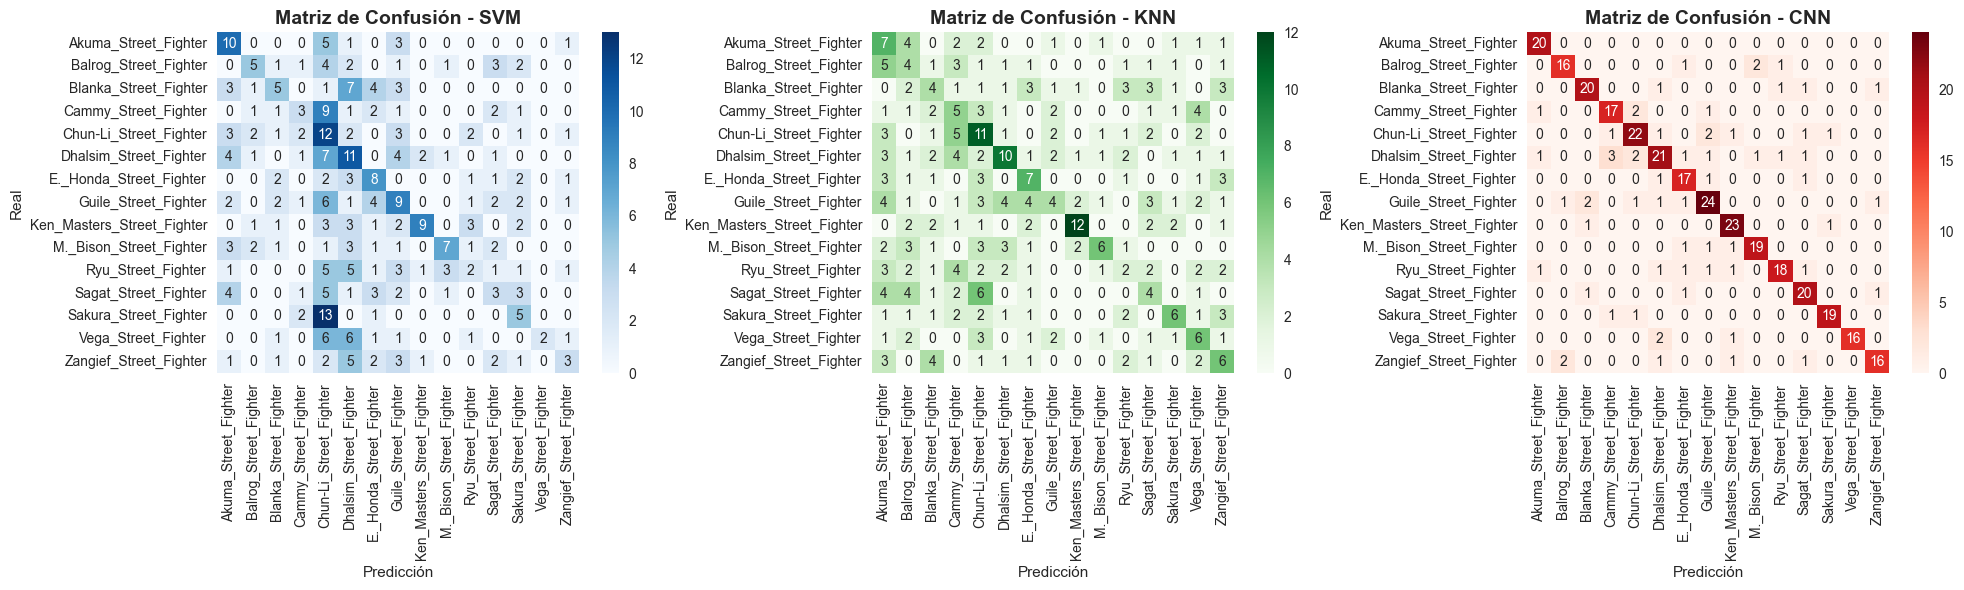

Métricas por clase:
                         Clase  SVM_Precision  SVM_Recall  SVM_F1  \
0         Akuma_Street_Fighter          0.323       0.500   0.392   
1        Balrog_Street_Fighter          0.385       0.250   0.303   
2        Blanka_Street_Fighter          0.312       0.208   0.250   
3         Cammy_Street_Fighter          0.273       0.143   0.188   
4       Chun-Li_Street_Fighter          0.148       0.414   0.218   
5       Dhalsim_Street_Fighter          0.216       0.344   0.265   
6      E._Honda_Street_Fighter          0.286       0.400   0.333   
7         Guile_Street_Fighter          0.250       0.290   0.269   
8   Ken_Masters_Street_Fighter          0.692       0.360   0.474   
9      M._Bison_Street_Fighter          0.538       0.318   0.400   
10          Ryu_Street_Fighter          0.182       0.083   0.114   
11        Sagat_Street_Fighter          0.176       0.130   0.150   
12       Sakura_Street_Fighter          0.250       0.238   0.244   
13         Veg

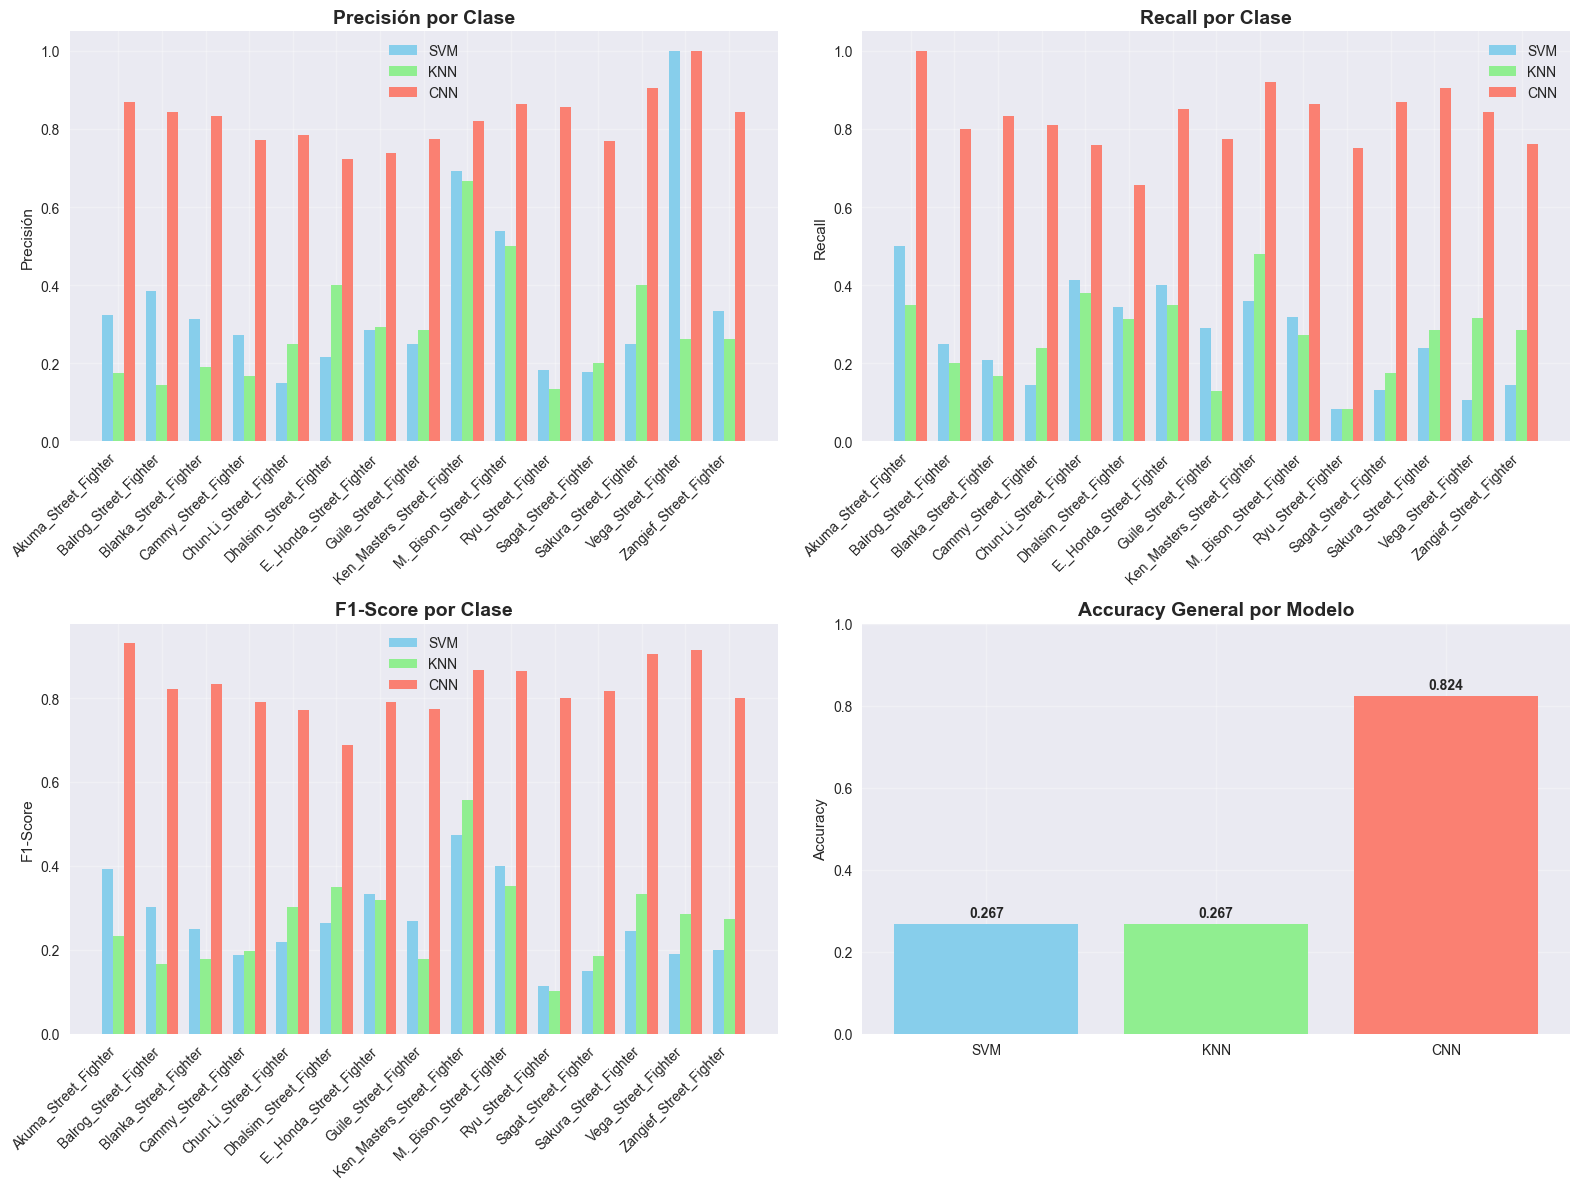


RESUMEN FINAL DE MODELOS
  Modelo  Accuracy  Precision_Promedio  Recall_Promedio  F1_Promedio  \
0    SVM     0.267               0.358            0.262        0.266   
1    KNN     0.267               0.288            0.268        0.268   
2    CNN     0.824               0.827            0.826        0.824   

   Tiempo_Inferencia_ms Complejidad Memoria_Requerida  
0                 1.108       Media              Baja  
1                 1.108        Baja              Baja  
2                 0.866        Alta              Alta  

MEJORES MODELOS POR MÉTRICA:
----------------------------------------
Mejor Accuracy: CNN (0.824)
Mejor Precision: CNN (0.827)
Mejor Recall: CNN (0.826)
Mejor F1-Score: CNN (0.824)
Más Rápido: CNN (0.87ms)


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import pandas as pd
import time
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configurar estilo para las gráficas
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# === 1. MATRICES DE CONFUSIÓN ===
def plot_confusion_matrices():
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Matriz de confusión SVM
    cm_svm = confusion_matrix(resultados_clasicos['y_test'], resultados_clasicos['svm_pred'])
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_title('Matriz de Confusión - SVM', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicción')
    axes[0].set_ylabel('Real')
    
    # Matriz de confusión KNN
    cm_knn = confusion_matrix(resultados_clasicos['y_test'], resultados_clasicos['knn_pred'])
    sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_title('Matriz de Confusión - KNN', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Predicción')
    axes[1].set_ylabel('Real')
    
    # Matriz de confusión CNN
    cm_cnn = confusion_matrix(resultados_cnn['y_test'], resultados_cnn['y_pred'])
    sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names, ax=axes[2])
    axes[2].set_title('Matriz de Confusión - CNN', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Predicción')
    axes[2].set_ylabel('Real')
    
    plt.tight_layout()
    plt.show()

# === 2. MÉTRICAS DETALLADAS POR CLASE ===
def analyze_detailed_metrics():
    # Obtener métricas para cada modelo
    svm_precision, svm_recall, svm_f1, _ = precision_recall_fscore_support(
        resultados_clasicos['y_test'], resultados_clasicos['svm_pred'], average=None)
    knn_precision, knn_recall, knn_f1, _ = precision_recall_fscore_support(
        resultados_clasicos['y_test'], resultados_clasicos['knn_pred'], average=None)
    cnn_precision, cnn_recall, cnn_f1, _ = precision_recall_fscore_support(
        resultados_cnn['y_test'], resultados_cnn['y_pred'], average=None)
    
    # Crear DataFrame para comparación
    metrics_df = pd.DataFrame({
        'Clase': class_names,
        'SVM_Precision': svm_precision,
        'SVM_Recall': svm_recall,
        'SVM_F1': svm_f1,
        'KNN_Precision': knn_precision,
        'KNN_Recall': knn_recall,
        'KNN_F1': knn_f1,
        'CNN_Precision': cnn_precision,
        'CNN_Recall': cnn_recall,
        'CNN_F1': cnn_f1
    })
    
    return metrics_df

# === 3. GRÁFICAS COMPARATIVAS ===
def plot_comparative_metrics(metrics_df):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Gráfica 1: Precisión por clase
    x = np.arange(len(class_names))
    width = 0.25
    
    axes[0,0].bar(x - width, metrics_df['SVM_Precision'], width, label='SVM', color='skyblue')
    axes[0,0].bar(x, metrics_df['KNN_Precision'], width, label='KNN', color='lightgreen')
    axes[0,0].bar(x + width, metrics_df['CNN_Precision'], width, label='CNN', color='salmon')
    axes[0,0].set_title('Precisión por Clase', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('Precisión')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Gráfica 2: Recall por clase
    axes[0,1].bar(x - width, metrics_df['SVM_Recall'], width, label='SVM', color='skyblue')
    axes[0,1].bar(x, metrics_df['KNN_Recall'], width, label='KNN', color='lightgreen')
    axes[0,1].bar(x + width, metrics_df['CNN_Recall'], width, label='CNN', color='salmon')
    axes[0,1].set_title('Recall por Clase', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Recall')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(class_names, rotation=45, ha='right')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Gráfica 3: F1-Score por clase
    axes[1,0].bar(x - width, metrics_df['SVM_F1'], width, label='SVM', color='skyblue')
    axes[1,0].bar(x, metrics_df['KNN_F1'], width, label='KNN', color='lightgreen')
    axes[1,0].bar(x + width, metrics_df['CNN_F1'], width, label='CNN', color='salmon')
    axes[1,0].set_title('F1-Score por Clase', fontsize=14, fontweight='bold')
    axes[1,0].set_ylabel('F1-Score')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Gráfica 4: Comparación general de accuracy
    models = ['SVM', 'KNN', 'CNN']
    accuracies = [resultados_clasicos['svm_accuracy'], 
                  resultados_clasicos['knn_accuracy'], 
                  resultados_cnn['test_accuracy']]
    
    bars = axes[1,1].bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
    axes[1,1].set_title('Accuracy General por Modelo', fontsize=14, fontweight='bold')
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].set_ylim(0, 1)
    axes[1,1].grid(True, alpha=0.3)
    
    # Añadir valores en las barras
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# === 4. TABLA RESUMEN COMPLETA ===
def create_summary_table(metrics_df, svm_time, cnn_time):
    # Calcular métricas promedio
    summary_data = {
        'Modelo': ['SVM', 'KNN', 'CNN'],
        'Accuracy': [
            resultados_clasicos['svm_accuracy'],
            resultados_clasicos['knn_accuracy'],
            resultados_cnn['test_accuracy']
        ],
        'Precision_Promedio': [
            metrics_df['SVM_Precision'].mean(),
            metrics_df['KNN_Precision'].mean(),
            metrics_df['CNN_Precision'].mean()
        ],
        'Recall_Promedio': [
            metrics_df['SVM_Recall'].mean(),
            metrics_df['KNN_Recall'].mean(),
            metrics_df['CNN_Recall'].mean()
        ],
        'F1_Promedio': [
            metrics_df['SVM_F1'].mean(),
            metrics_df['KNN_F1'].mean(),
            metrics_df['CNN_F1'].mean()
        ],
        'Tiempo_Inferencia_ms': [svm_time, svm_time, cnn_time],  # Aproximado para KNN
        'Complejidad': ['Media', 'Baja', 'Alta'],
        'Memoria_Requerida': ['Baja', 'Baja', 'Alta']
    }
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

# === EJECUTAR ANÁLISIS COMPLETO ===
print("ANÁLISIS COMPLETO DE MODELOS")
print("=" * 60)

# 1. Mostrar matrices de confusión
plot_confusion_matrices()

# 2. Analizar métricas detalladas
metrics_df = analyze_detailed_metrics()
print("Métricas por clase:")
print(metrics_df.round(3))

# 3. Mostrar gráficas comparativas
plot_comparative_metrics(metrics_df)

# 4. Crear tabla resumen
summary_df = create_summary_table(metrics_df, svm_time, cnn_time)

print("\n" + "="*80)
print("RESUMEN FINAL DE MODELOS")
print("="*80)
print(summary_df.round(3))

# Análisis de mejor modelo por métrica
print("\nMEJORES MODELOS POR MÉTRICA:")
print("-" * 40)
best_accuracy = summary_df.loc[summary_df['Accuracy'].idxmax(), 'Modelo']
best_precision = summary_df.loc[summary_df['Precision_Promedio'].idxmax(), 'Modelo']
best_recall = summary_df.loc[summary_df['Recall_Promedio'].idxmax(), 'Modelo']
best_f1 = summary_df.loc[summary_df['F1_Promedio'].idxmax(), 'Modelo']
fastest = summary_df.loc[summary_df['Tiempo_Inferencia_ms'].idxmin(), 'Modelo']

print(f"Mejor Accuracy: {best_accuracy} ({summary_df['Accuracy'].max():.3f})")
print(f"Mejor Precision: {best_precision} ({summary_df['Precision_Promedio'].max():.3f})")
print(f"Mejor Recall: {best_recall} ({summary_df['Recall_Promedio'].max():.3f})")
print(f"Mejor F1-Score: {best_f1} ({summary_df['F1_Promedio'].max():.3f})")
print(f"Más Rápido: {fastest} ({summary_df['Tiempo_Inferencia_ms'].min():.2f}ms)")


## Guardado de los modelos

In [11]:
# Guardar modelos y clases entrenadas
import pickle

# Guardar modelo clásico y scaler
with open('classical_model.pkl', 'wb') as f:
    pickle.dump(resultados_clasicos['mejor_modelo'], f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(resultados_clasicos['scaler'], f)

import torch
# Guardar modelo CNN (PyTorch)
torch.save(resultados_cnn['modelo'].state_dict(), 'cnn_model.pth')

# Guardar nombres de clases
with open('class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)

## **Interfaz gráfica del proyecto**

## **Detección en tiempo real con cámara**

Para realizar la detección en tiempo real de personajes de Street Fighter utilizando la cámara del celular, se ha modificado el archivo `detector_video.py`. Este archivo utiliza OpenCV para capturar video en tiempo real y el modelo CNN entrenado para identificar personajes en cada frame.

### Pasos para ejecutar la detección:
1. Asegúrate de que los modelos entrenados (`cnn_model.pth` y `class_names.pkl`) estén en el mismo directorio que el archivo `detector_video.py`.
2. Conecta tu celular como cámara mediante herramientas como DroidCam.
3. Ejecuta el archivo `detector_video.py`:
   ```python
   python detector_video.py
   ```
4. Observa los resultados en tiempo real en la ventana de OpenCV.

### Resultados esperados:
- El nombre del personaje detectado y la confianza se mostrarán en cada frame capturado.
- Presiona la tecla `q` para salir del programa.

In [12]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
import pickle

# Cargar nombres de clases
with open("class_names.pkl", "rb") as f:
    class_names = pickle.load(f)

# Definir el modelo
def crear_modelo(num_clases):
    model = resnet50(weights=None)
    model.fc = nn.Sequential(
        nn.BatchNorm1d(model.fc.in_features),
        nn.Dropout(0.5),
        nn.Linear(model.fc.in_features, num_clases)
    )
    return model

# Cargar pesos entrenados
model = crear_modelo(len(class_names))
model.load_state_dict(torch.load("cnn_model.pth", map_location="cpu"))
model.eval()

# Convertir a TorchScript
example_input = torch.rand(1, 3, 224, 224)
traced_model = torch.jit.trace(model, example_input)
traced_model.save("cnn_model_mobile.pt")

print("✅ Modelo convertido y guardado como cnn_model_mobile.pt")


C:\Users\Rafael Chui\AppData\Local\Temp\ipykernel_38496\2681711566.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_model.pth", map

✅ Modelo convertido y guardado como cnn_model_mobile.pt
